In [79]:
%pylab inline
import sklearn
import sklearn.datasets

import matplotlib.gridspec as gridspec

from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Let's generate some data first:

(-4.0, 8.0, -15.0, 10.0)

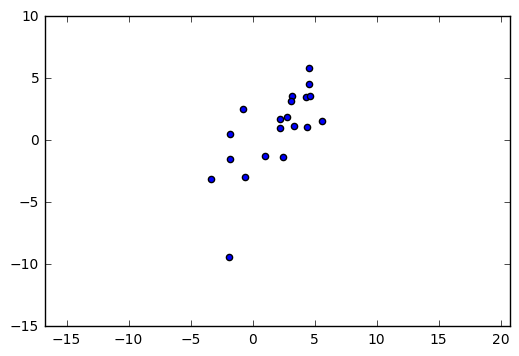

In [80]:
X = np.array([[1,3],[3,1]]).dot(np.random.randn(2,20))+[[1.0],[1.0]]
Xcolors = (X[0,:]-min(X[0,:]))/(max(X[0,:])-min(X[0,:]))
Xcolors = pylab.cm.jet(Xcolors)

scatter(X[0,:], X[1,:]) #, color=Xcolors)
axis('equal')

Now subtract the mean and normalize the data such that each dimension has unit variance

In [81]:
Xorig = np.array(X)
X -= X.mean(1).reshape([-1,1])
X /= X.std(1).reshape([-1,1])

In [82]:
#create a grid
xmin,xmax = floor(X.min(1)), ceil(X.max(1))
xg,yg=meshgrid(arange(xmin[0],xmax[0]+.5,0.5), arange(xmin[1], xmax[1]+.5, 0.5))
mxg = hstack((hstack((xg, zeros((xg.shape[0],1))+nan)).ravel(), hstack((xg.T, zeros((xg.shape[1],1))+nan)).ravel()))
myg = hstack((hstack((yg, zeros((yg.shape[0],1))+nan)).ravel(), hstack((yg.T, zeros((yg.shape[1],1))+nan)).ravel()))
G = vstack((mxg,myg))

In [83]:
def plot_marginals(gs, axis, data):
    if axis==1:
        ax = subplot(gs[0,0])
        data = data[1,:]
    else:
        ax = subplot(gs[1,1])
        data = data[0,:]
    xx = linspace(data.min(), data.max(), 100)
    yy = norm.pdf(xx, loc=data.mean(), scale=data.std())
    if axis == 1:
        ax.plot(yy,xx)
        ax.invert_xaxis()
    else:
        ax.plot(xx,yy)
        ax.invert_yaxis()
    ax.set_axis_off()    

(-4.0, 3.0, -3.0, 3.0)

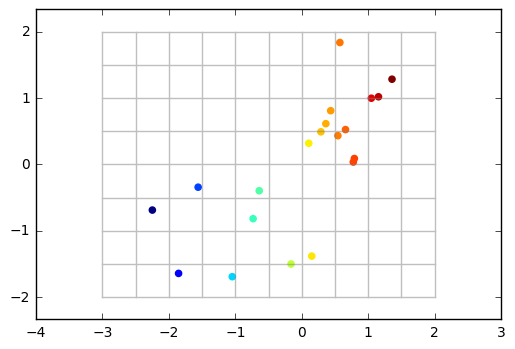

In [6]:
if 0: # If true, will plot marginals of data
    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[1,3],
                           height_ratios=[3,1]
                           )

    plot_marginals(gs, 0, X)
    plot_marginals(gs, 1, X)
    subplot(gs[0,1])
plot(G[0,:], G[1,:],color='gray', alpha=0.5)
scatter(X[0,:], X[1,:], color=Xcolors)
axis('equal')

# Theory of PCA

We will describe the PCA algorithm in two phases - first, we will describe how to compute the first PCA component. Then we will generalize it to more components.

## Only one component


We want to find a projection direction $v$ that will capture the most of data variance.


The projected data is:

$$ v^T X $$

Let $ \overline{v^TX} $ be the mean value of the projection. 

The variance of the projection is:

$$ \frac{1}{N}\left(v^TX - \overline{v^TX}\right)\left(v^TX - \overline{v^TX}\right)^T $$

By noting that $ \overline{v^TX} = v^T\sum_{i=1}^{N}x^{(i)} = v^T\overline{X} $ we compute the variance of the projection as:

$$ \frac{1}{N}v^T(X-\overline{X})(X-\overline{X})^Tv $$

We will call $ S = (X-\overline{X})(X-\overline{X})^T $ to be the data covariance matrix. 

The 1D PCA problem is thus finding a direction $v^*$ such that:

$$ v^* =\text{argmax}_v v^T S v $$

Since we only want the direction, we can constrain $v^*$ to have unit length: $v^T v =1$. To solve the resulting constrained optimization problem we will use lagrange multipliers. The Lagrangian is:

$$ L(v, \lambda) = v^TSv - \lambda(v^Tv-1) $$

We solve by looking at the gradient:

$$ \frac{\partial L}{\partial v} = Sv - \lambda v $$

At the optimum the gradient is $0$, thus:

$$ Sv - \lambda v = 0 $$

Therefore the vector $v$ is the eigenvector of $S$ with the largest eigenvalue!

## Multidimensional PCA

The reasoning above generalizes to many dimensions. The general solution to the PCA problem is to project the data onto the $k$ eigenvectors associated with the $k$ largest eigenvalues.


In [84]:
#Compute the covariance matrix

S = 1.0/X.shape[1] * X.dot(X.T)
print S

Shape: (2, 2)
[[ 1.          0.70784022]
 [ 0.70784022  1.        ]]


In [85]:
L,V = eig(S)
eigorder = L.argsort()[::-1]
L = L[eigorder]
V = V[:,eigorder]
print 'L=',L,'\nV=',V

L= Shape: (2,)
[ 1.70784022  0.29215978] 
V= Shape: (2, 2)
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


(-2.5, 2.0, -4.0, 2.0)

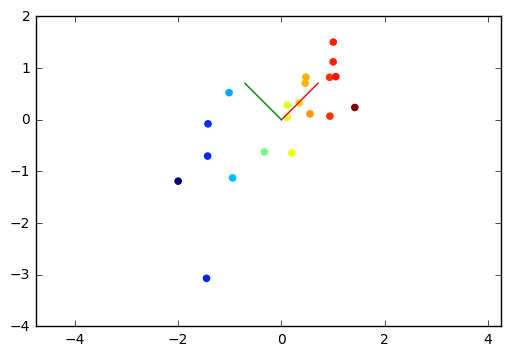

In [86]:
scatter(X[0,:], X[1,:], color=Xcolors)
plot([0,V[0,0]], [0, V[1,0]], 'r')
plot([0,V[0,1]], [0, V[1,1]], 'g')
axis('equal')

Rotate the data into PCA space

In [87]:
XPCA  = V.T.dot(X)
GPCA = V.T.dot(G)
VPCA = V.T.dot(V) #this will be the identity matrix!!

(-5.0, 4.0, -5.0, 4.0)

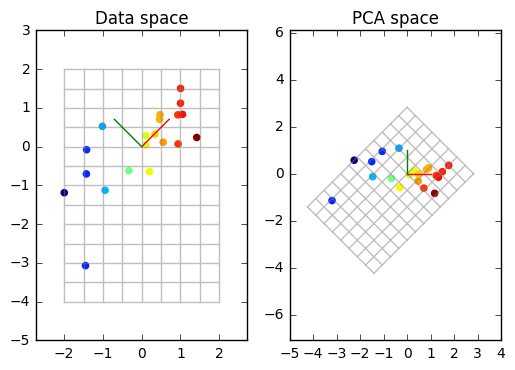

In [88]:
subplot(121)
axis('equal')
title('Data space')
plot(G[0,:], G[1,:], color='gray', alpha=0.5)
scatter(X[0,:], X[1,:], color=Xcolors)
plot([0,V[0,0]], [0, V[1,0]], 'r')
plot([0,V[0,1]], [0, V[1,1]], 'g')
axis('equal')


subplot(122)
axis('equal')
title('PCA space')
plot(GPCA[0,:], GPCA[1,:], color='gray', alpha=0.5)
scatter(XPCA[0,:], XPCA[1,:], color=Xcolors)
plot([0,VPCA[0,0]], [0, VPCA[1,0]], 'r')
plot([0,VPCA[0,1]], [0, VPCA[1,1]], 'g')
axis('equal')


# ZCA transformation

We can think of PCA as of a rigid rotation of the data. In the PCA space the marginal variances are different for each axis (they correspond to the eigenvalues).

What will happen if we scale the data (in the PCA space) to have unit variance along each axis, then rotate it back?
This is exactly what ZCA (Zero Component Analysis) does!

Technically, we get back data that is decorrelated and as close as possible to the original one (in the least squares sense)!

## Demonstration

Now let's try the ZCA:

$Z = V \Sigma^{-1/2} V^T$

Note: $Z$ is symmetric, i.e. $Z=Z^T$

In [89]:
Z = V.dot(diag(1.0/(sqrt(L)+1e-4))).dot(V.T)
ZZ=inv(Z)

XZCA  = Z.dot(X)
GZCA = Z.dot(G)
ZZCA = Z.dot(ZZ) #note: this is the identity matrix!

(-6.0, 6.0, -8.0, 6.0)

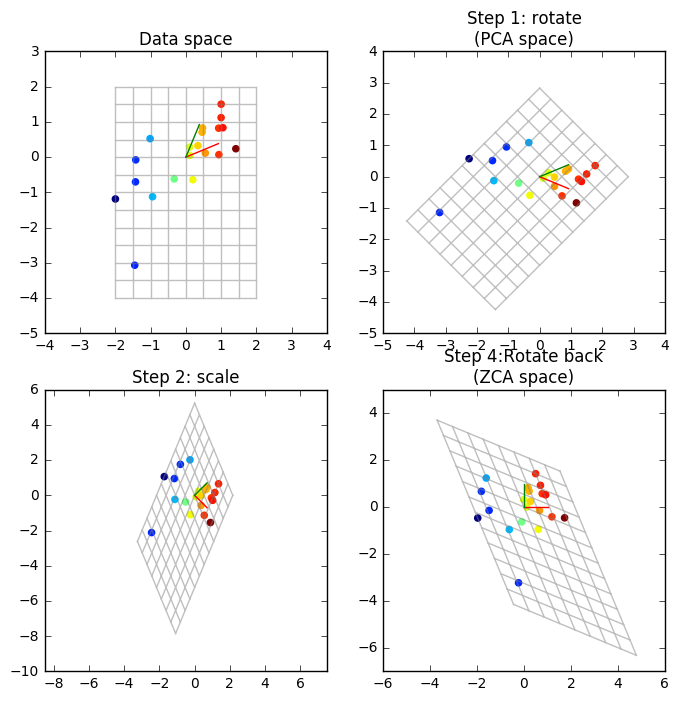

In [90]:
figure(figsize=(8,8))
subplot(221)
title('Data space')
plot(G[0,:], G[1,:], color='gray', alpha=0.5)
plot([0,ZZ[0,0]], [0, ZZ[1,0]], 'r')
plot([0,ZZ[0,1]], [0, ZZ[1,1]], 'g')
scatter(X[0,:], X[1,:], color=Xcolors)
axis('equal')

subplot(222)
title('Step 1: rotate\n(PCA space)')
X1 = V.T.dot(X)
G1 = V.T.dot(G)
ZZ1 = V.T.dot(ZZ)
plot(G1[0,:], G1[1,:], color='gray', alpha=0.5)
plot([0,ZZ1[0,0]], [0, ZZ1[1,0]], 'r')
plot([0,ZZ1[0,1]], [0, ZZ1[1,1]], 'g')
scatter(X1[0,:], X1[1,:], color=Xcolors)
axis('equal')

subplot(223)
title('Step 2: scale')
X2 = diag(1.0/(sqrt(L)+1e-4)).dot(X1)
G2 = diag(1.0/(sqrt(L)+1e-4)).dot(G1)
ZZ2 = diag(1.0/(sqrt(L)+1e-4)).dot(ZZ1)
plot(G2[0,:], G2[1,:], color='gray', alpha=0.5)
plot([0,ZZ2[0,0]], [0, ZZ2[1,0]], 'r')
plot([0,ZZ2[0,1]], [0, ZZ2[1,1]], 'g')
scatter(X2[0,:], X2[1,:], color=Xcolors)
axis('equal')


subplot(224)
title('Step 4:Rotate back\n(ZCA space)')
plot(GZCA[0,:], GZCA[1,:], color='gray', alpha=0.5)
scatter(XZCA[0,:], XZCA[1,:], color=Xcolors)
plot([0,ZZCA[0,0]], [0, ZZCA[1,0]], 'r')
plot([0,ZZCA[0,1]], [0, ZZCA[1,1]], 'g')
axis('equal')

ZCA Whitening is useful for images: the transformed images have decorrelated pixels, yet are close (in the L2 sense) to the original images.

In [38]:
from fuel.datasets.mnist import MNIST
from common.plotting import plot_mat

mnist_train = MNIST(("train",), subset=slice(None,50000))
mnist_train_X = mnist_train.data_sources[0] / (255./2.) - 1.0

mnist_train_X_flat = mnist_train_X.reshape([mnist_train_X.shape[0], -1])
mnist_train_X_flat_norm = mnist_train_X_flat - mnist_train_X_flat.mean(axis=0, keepdims=True)

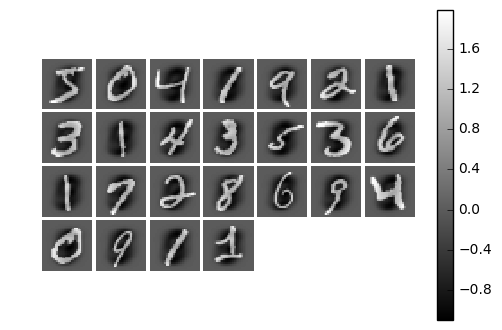

In [39]:
plot_mat(mnist_train_X_flat_norm[:25].reshape(-1, 1, 28, 28), scaleIndividual=False, colorbar=True)

In [40]:
X.shape

(2, 60)

In [41]:
S = mnist_train_X_flat_norm.T.dot(mnist_train_X_flat_norm) /mnist_train_X_flat_norm.shape[0]
S.shape

(784, 784)

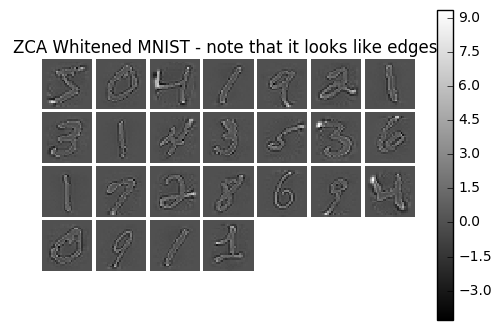

In [78]:
L,V = eig(S)
L = np.real(L)
V = np.real(V)
eigorder = L.argsort()[::-1]
L = L[eigorder]
V = V[:,eigorder]

L[L<1e-2] = 1.0 # note- the zero eigenvalues cause a problem!

Z = V.dot(diag(1.0/(sqrt(L)))).dot(V.T)

mnist_ZCA  = Z.dot(mnist_train_X_flat_norm.T).T

plot_mat(mnist_ZCA[:25].reshape(-1, 1, 28, 28), scaleIndividual=False, colorbar=True)
plt.title('ZCA Whitened MNIST - note that it looks like edges!')

# Back to PCA

In [91]:
iris = sklearn.datasets.load_iris()
irisX = iris.data.T
irisY = iris.target

L= Shape: (4,)
[ 2.91081808  0.92122093  0.14735328  0.02060771] 
V= Shape: (4, 4)
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


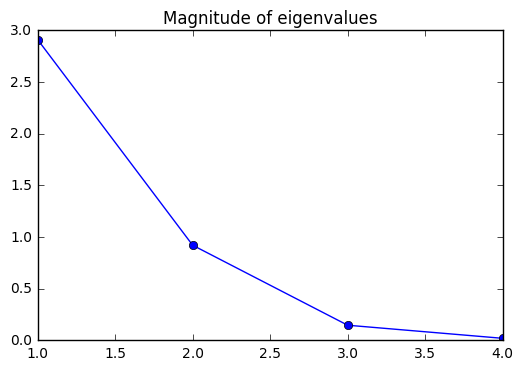

In [92]:
irisX -= irisX.mean(1).reshape([-1,1])
irisX /= irisX.std(1).reshape([-1,1])

S = irisX.dot(irisX.T) / irisX.shape[1]
L, V = eig(S)
eigorder = L.argsort()[::-1]
L = L[eigorder]
V = V[:,eigorder]
print 'L=',L,'\nV=',V
title('Magnitude of eigenvalues')
plot(arange(L.shape[0])+1, L, '-o')

In [93]:
#keep only 2 eigenvectors:
LK = L[:2]
VK = V[:,:2]

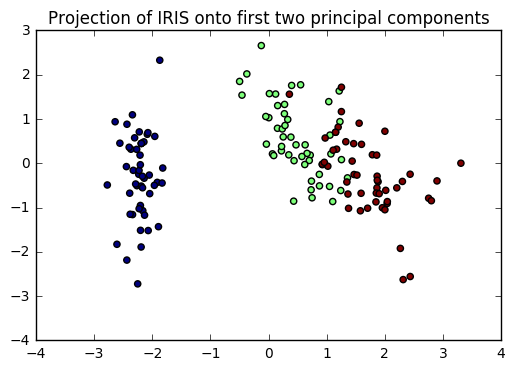

In [17]:
irisX = VK.T.dot(irisX)

scatter(irisX[0,:], irisX[1,:], c=irisY, cmap=jet())
title('Projection of IRIS onto first two principal components')

In [94]:
F = sklearn.datasets.olivetti_faces.fetch_olivetti_faces().data.T
F = F-F.mean(0)
F.shape

(4096, 400)

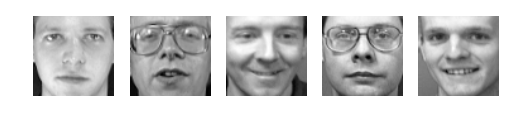

In [95]:
gray()
for i in range(5):
    subplot(1,5,i+1)
    imshow(F[:,i*10].reshape((64,64)))
    axis('off')


In [20]:
SSmall = F.T.dot(F)/F.shape[1]
SSmall.shape

(400, 400)

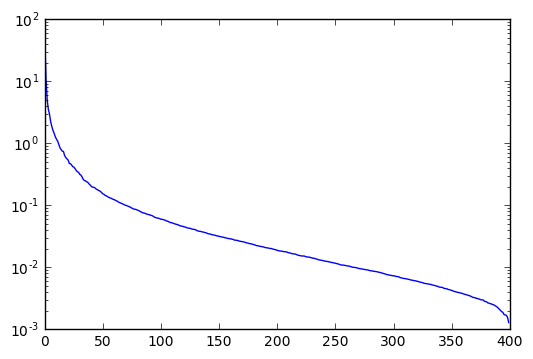

In [96]:
L,U = eig(SSmall)
L=real(L); U=real(U) #discard imaginary parts that are due to numerical errors
eigorder = L.argsort()[::-1]
L = L[eigorder]
U = U[:,eigorder]

semilogy(L)

In [107]:
K = 50
LK = L[:K]
UK = U[:,:K]

VK = F.dot(UK.dot(diag(1.0/sqrt(F.shape[1]*LK))))

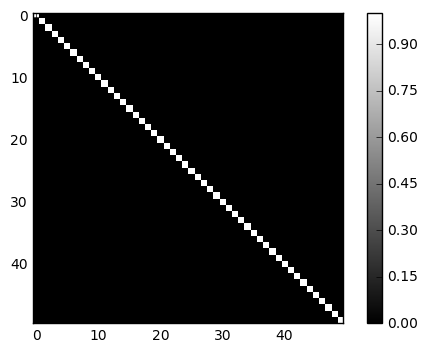

In [108]:
#check that the columns of VK are indeed orthonormal
imshow(VK.T.dot(VK), interpolation='nearest')
plt.colorbar()

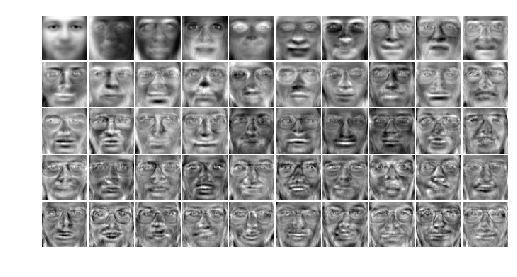

In [109]:
from common.plotting import plot_mat
plot_mat(VK.T.reshape(-1, 1, 64, 64))

project faces to the dim spanned by first three eigenvectors

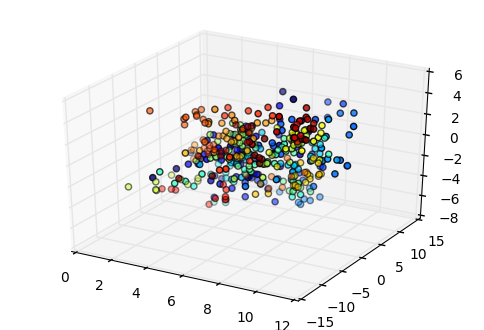

In [110]:
from mpl_toolkits.mplot3d import Axes3D
FPCA = VK[:,:3].T.dot(F)
ax=figure().add_subplot(111, projection='3d')
ax.scatter(FPCA[0,:],FPCA[1,:],FPCA[2,:], c=floor(np.arange(400.0)/10), cmap=pylab.cm.jet)

Now lets generate data to show off Kernel PCA

(-4.0, 4.0, -4.0, 4.0)

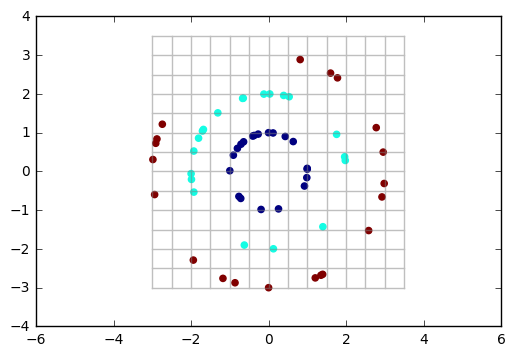

In [112]:
a = np.random.rand(20)*2*pi
X=[]
for r in [1,2,3]:
        a=np.random.rand(20)*2*pi
        X.append(np.array([np.cos(a), np.sin(a)])*r)
        
X=np.hstack(X)

Xcolors = (X**2).sum(0)
Xcolors = (Xcolors-min(Xcolors))/(max(Xcolors) - min(Xcolors))
Xcolors = pylab.cm.jet(Xcolors)

xmin,xmax = floor(X.min(1)), ceil(X.max(1))
xg,yg=meshgrid(arange(xmin[0],xmax[0]+1,0.5), arange(xmin[1], xmax[1]+1, 0.5))
mxg = hstack((hstack((xg, zeros((xg.shape[0],1))+nan)).ravel(), hstack((xg.T, zeros((xg.shape[1],1))+nan)).ravel()))
myg = hstack((hstack((yg, zeros((yg.shape[0],1))+nan)).ravel(), hstack((yg.T, zeros((yg.shape[1],1))+nan)).ravel()))
G = vstack((mxg,myg))

plot(G[0,:], G[1,:], color='gray', alpha=0.5)
scatter(X[0,:], X[1,:], color=Xcolors)
axis('equal')

PCA will not transform this data significantly:

(-5.0, 5.0, -5.0, 5.0)

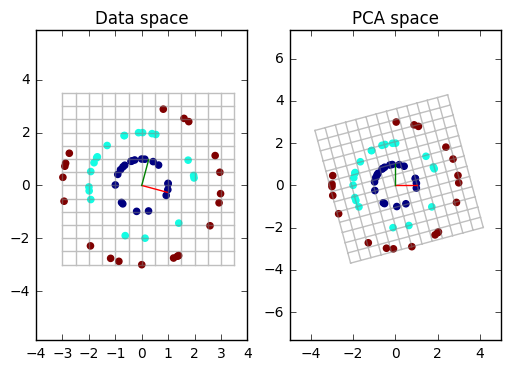

In [113]:
S = 1.0/X.shape[1] * X.dot(X.T)
L,V = eig(S)
eigorder = L.argsort()[::-1]
L = L[eigorder]
V = V[:,eigorder]
XPCA  = V.T.dot(X)
GPCA = V.T.dot(G)
VPCA = V.T.dot(V) #this will be the identity matrix!!
subplot(121)
title('Data space')
plot(G[0,:], G[1,:], color='gray', alpha=0.5)
scatter(X[0,:], X[1,:], color=Xcolors)
plot([0,V[0,0]], [0, V[1,0]], 'r')
plot([0,V[0,1]], [0, V[1,1]], 'g')
axis('equal')
subplot(122)
title('PCA space')
plot(GPCA[0,:], GPCA[1,:], color='gray', alpha=0.5)
scatter(XPCA[0,:], XPCA[1,:], color=Xcolors)
plot([0,VPCA[0,0]], [0, VPCA[1,0]], 'r')
plot([0,VPCA[0,1]], [0, VPCA[1,1]], 'g')
axis('equal')

Let's try to use a polynomial kernel!

Shape: (8,)
[  1.04149404e+03   6.08470349e+02   4.02692313e+02   2.90380983e+02
   2.19677181e+02   1.72851368e+01   6.67016192e-14   5.53804802e-14]


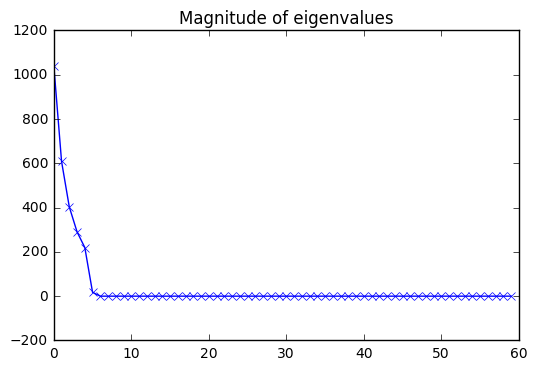

In [117]:
def kern(X,Y):
    return (X.T.dot(Y)+1.0)**2

K = kern(X,X)
L,U = eig(K)
L=real(L); U=real(U) #discard imaginary parts that are due to numerical errors
eigorder = L.argsort()[::-1]
L = L[eigorder]
U = U[:,eigorder]

print L[:8]
plot(L, 'x-')
title('Magnitude of eigenvalues')

Let's keep only the 2 most important eigenvalues

In [119]:
U2 = U[:,:2]
L2 = L[:2]
XKPCA = diag(1.0/sqrt(X.shape[1]*L2)).dot(U2.T).dot(K)
GKPCA = diag(1.0/sqrt(X.shape[1]*L2)).dot(U2.T).dot(kern(X,G))

(-0.5, 2.5, -1.0, 2.0)

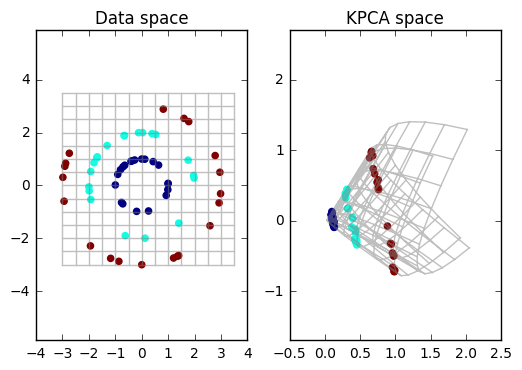

In [120]:
subplot(121)
title('Data space')
plot(G[0,:], G[1,:], color='gray', alpha=0.5)
scatter(X[0,:], X[1,:], color=Xcolors)
axis('equal')
subplot(122)
title('KPCA space')
plot(GKPCA[0,:], GKPCA[1,:], color='gray', alpha=0.5)
scatter(XKPCA[0,:], XKPCA[1,:], color=Xcolors)
axis('equal')